## Data loading

In [ ]:
import os

from speakleash import Speakleash
from typing import Iterator, List
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
replicate_to = os.path.join(".", "data")

sl = Speakleash(replicate_to)


data_gen = sl.get("wolne_lektury_corpus").data
data_list = list(data_gen)

Error downloading manifest https://d6t0.c15.e2-2.dev/speakleash-ds-pub/datasets_text/web_artykuły_inne_27.manifest


In [2]:
num_docs = len(data_list)

total_chars = sum(len(doc) for doc in data_list)

total_words = sum(len(doc.split()) for doc in data_list)

avg_words_per_doc = total_words / num_docs
avg_chars_per_doc = total_chars / num_docs

min_words = min(len(doc.split()) for doc in data_list)
max_words = max(len(doc.split()) for doc in data_list)
min_chars = min(len(doc) for doc in data_list)
max_chars = max(len(doc) for doc in data_list)

print(f"Liczba dokumentów: {num_docs}")
print(f"Łączna liczba znaków: {total_chars}")
print(f"Łączna liczba słów: {total_words}")
print(f"Średnia liczba znaków na dokument: {avg_chars_per_doc:.1f}")
print(f"Średnia liczba słów na dokument: {avg_words_per_doc:.1f}")
print(f"Najkrótszy dokument: {min_words} słów, {min_chars} znaków")
print(f"Najdłuższy dokument: {max_words} słów, {max_chars} znaków")

Liczba dokumentów: 6619
Łączna liczba znaków: 262196111
Łączna liczba słów: 40323342
Średnia liczba znaków na dokument: 39612.6
Średnia liczba słów na dokument: 6092.1
Najkrótszy dokument: 4 słów, 35 znaków
Najdłuższy dokument: 384639 słów, 2438186 znaków


In [ ]:
text = data_list[0]

splited = text.split("\n")

for l in splited[:20]:
    if l:
        print("#########")
        print(l)

#########
Jules Verne
#########
20 000 mil podmorskiej żeglugi
#########
tłum. tłumacz nieznany
#########
ISBN 978-83-288-2922-0
#########
Skała uciekająca
#########
Nie zapomniano zapewne dotąd wypadku dziwnego, niepojętego i trudnego do objaśnienia zjawiska, jakim się odznaczył rok 1866. Nie mówiąc już o pogłoskach niepokojących ludność portów i zajmujących ogół na wszystkich lądach, dodać wypada, że marynarze byli najmocniej zaniepokojeni. Kupcy, armatorzy, dowódcy okrętów, szyprowie i sternicy statków europejskich i amerykańskich, oficerowie marynarki wojennej wszystkich krajów, a nawet rządy różnych państw obu lądów do najwyższego stopnia zajęci byli tym wydarzeniem.
#########
Od niejakiego czasu okręty napotykały na morzu „jakąś rzecz ogromną”, przedmiot długi, kształtu wrzecionowatego, niekiedy świecący, nieskończenie większy i szybszy od wieloryba.
#########
Fakty tyczące się tego zjawiska, notowane w dziennikach okrętowych, zgadzały się zupełnie w szczegółach o budowie przedmi

## Tokenizer

Token - jest to po prostu jednostka tekstu, którą model traktuje jako pojedynczy element.

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dkleczek/bert-base-polish-uncased-v1")

text = "Siemanko witam w mojej kuchni - rabarbar to fajne słowo"
tokens = tokenizer.tokenize(text)
ids = tokenizer(text)["input_ids"]

print(f"Tokens: {tokens}")
print(f"Ids: {ids}")

Tokens: ['siemanko', 'witam', 'w', 'mojej', 'kuchni', '-', 'rab', '##ar', '##bar', 'to', 'fajne', 'słowo']
Ids: [2, 56479, 4518, 65, 3130, 7729, 17, 14876, 1913, 3550, 1907, 11420, 5025, 4]


### Creating dataset

Dataset jest tworzony w ten sposób że:


1) parsujemy książke na linijki
2) usuwamy linie krótsze niż 20 znaków zakładając żę to syf 
3) tokenizujemy całą książkę (jako liste linijek)
4) chunkujemy w taki sposób, że przesuwamy stridem 64 -> np. chunk1 i chunk2 się pokrywają w połowie, że chunk1[64:] = chunk2[:64], dodatkowo labaele
5) zrzucamy na dataset torchowy

In [6]:
class LanguageModelingDataset(Dataset):
    def __init__(self, inputs, labels):
        print(f"Inputs type: {type(inputs)}, len={len(inputs)}")
        print(f"Labels type: {type(labels)}, len={len(labels)}")
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]


def collate_fn(batch):
    X_batch, y_batch = zip(*batch)
    print([len(x) for x in X_batch])
    X_batch = torch.tensor(X_batch, dtype=torch.long)
    y_batch = torch.tensor(y_batch, dtype=torch.long)
    return X_batch, y_batch


def is_line_valuable(line: str) -> bool:
    return len(line) > 20


def parse_book_to_lines(book: str) -> Iterator[str]:
    lines = []
    splited = book.split("\n")
    for line in splited:
        if is_line_valuable(line):
            lines.append(line)

    return lines


def make_chunks(tokens, seq_len=128, stride=64):
    chunks_input = []
    chunks_label = []

    for i in range(0, len(tokens) - seq_len, stride):
        chunk = tokens[i : i + seq_len]
        chunks_input.append(chunk[:-1])
        chunks_label.append(chunk[1:])
    return chunks_input, chunks_label


def prepare_dataset(texts: List[str], seq_len=128, stride=64) -> Dataset:
    all_inputs = []
    all_labels = []

    for i, text in enumerate(texts):
        lines = parse_book_to_lines(text)
        if not lines:
            print(f"Skipping empty book {i}")
            continue

        encodings = tokenizer(
            lines,
            padding=False,
            truncation=True,
            max_length=seq_len,
        )

        if not encodings["input_ids"]:
            print(f"No tokens for book {i}, skipping")
            continue

        book_tokens = []
        for ids in encodings["input_ids"]:
            book_tokens.extend(ids)

        inputs, labels = make_chunks(book_tokens, seq_len=seq_len, stride=stride)
        all_inputs.extend(inputs)
        all_labels.extend(labels)

        print(f"Parsed: {i + 1}/{len(texts)}")

    dataset = LanguageModelingDataset(all_inputs, all_labels)
    return dataset

In [39]:
sml_dataset = prepare_dataset(data_list[:2])

Parsed: 1/2
Parsed: 2/2


In [40]:
tokenizer.decode(sml_dataset[3]["input_ids"])

'wieloryba. [SEP] [CLS] fakty tyczace sie tego zjawiska, notowane w dziennikach okretowych, zgadzały sie zupełnie w szczegołach o budowie przedmiotu, czy tez jestestwa, o ktorym mowa, rowniez jak o szybkosci niesłychanej jego ruchow, zadziwiajacej sile posuwania sie, o zywotnosci nareszcie szczegolnej, jaka zdawał sie byc obdarzony. jesli to był wieloryb, to wielkoscia przewyzszał wszystkie gatunki, jakie nauka dotad okresliła. ani cuvier, ani lacepede, ani dumeril, ani de quatrefages nigdzie dotad nie wspomnieli'

In [13]:
def create_and_save_dataset(speakleash_dataset_nane: str, dataset_path: str):
    replicate_to = os.path.join(".", "data")
    sl = Speakleash(replicate_to)
    data_gen = sl.get(speakleash_dataset_nane).data

    print(f"Loaded {speakleash_dataset_nane} from speakleash")
    data_gen = list(data_gen)
    dataset = prepare_dataset(data_gen)

    torch.save(
        {
            "inputs": dataset.X,
            "labels": dataset.y,
        },
        dataset_path,
    )
    print(f"Saved dataset at: {dataset_path}")

In [14]:
create_and_save_dataset("wolne_lektury_corpus", "datasets/wolne_lektury_dataset.pt")

Error downloading manifest https://d6t0.c15.e2-2.dev/speakleash-ds-pub/datasets_text/web_artykuły_inne_27.manifest
Loaded wolne_lektury_corpus from speakleash
Parsed: 1/6619
Parsed: 2/6619
Parsed: 3/6619
Parsed: 4/6619
Parsed: 5/6619
Parsed: 6/6619
Parsed: 7/6619
Parsed: 8/6619
Parsed: 9/6619
Parsed: 10/6619
Parsed: 11/6619
Parsed: 12/6619
Parsed: 13/6619
Parsed: 14/6619
Parsed: 15/6619
Parsed: 16/6619
Parsed: 17/6619
Parsed: 18/6619
Parsed: 19/6619
Parsed: 20/6619
Parsed: 21/6619
Parsed: 22/6619
Parsed: 23/6619
Parsed: 24/6619
Parsed: 25/6619
Parsed: 26/6619
Parsed: 27/6619
Parsed: 28/6619
Parsed: 29/6619
Parsed: 30/6619
Parsed: 31/6619
Parsed: 32/6619
Parsed: 33/6619
Parsed: 34/6619
Parsed: 35/6619
Parsed: 36/6619
Parsed: 37/6619
Parsed: 38/6619
Parsed: 39/6619
Parsed: 40/6619
Parsed: 41/6619
Parsed: 42/6619
Parsed: 43/6619
Parsed: 44/6619
Parsed: 45/6619
Parsed: 46/6619
Parsed: 47/6619
Parsed: 48/6619
Parsed: 49/6619
Parsed: 50/6619
Parsed: 51/6619
Parsed: 52/6619
Parsed: 53/6619
Pa

In [ ]:
training_checkpoint = torch.load("datasets/wolne_lektury_dataset.pt")
dataset = LanguageModelingDataset(
    training_checkpoint["inputs"], training_checkpoint["labels"]
)
print(f"Liczba elementów w dataset: {len(dataset)}")

sample = dataset[0]
print(sample["input_ids"].shape)
print(tokenizer.decode(sample["input_ids"]))
print(sample["labels"].shape)

In [14]:
print(sample)


{'input_ids': tensor([    2,  2167,  4346,  4146,  2011, 19634,  2594,  2095, 37153,  2099,
            4,     2, 14086,    18, 25432, 23316,     4,     2,  5746,  1028,
         1007, 13607,  1062,    17, 15276,    17,  5128,  1062,    17,  5095,
        13046,    17,    20,     4,     2,  1893, 17533,  2637,  8263,  7426,
         2026,  5526, 10161,    16,  4208, 44443,  2061,    51, 35908,  1906,
         7400,  1011,  3318, 20733,    16,  4207,  2243, 11470,  3283,  3874,
        44655,    18,  1893, 18803, 16609,  9437,    57, 21933, 11062,  9008,
        48544,  1897,  5125, 38685, 33163,  1022,    51,  8197, 48544,  1897,
        11267,  1019,  1898,  2865, 17875,  1897,    16, 36563,  1015, 22196,
           16,  2095, 47093,  1014,  3836, 30553, 25055, 45237,    18, 55821,
           16, 21399,  2665,    16,  5488,  1978,  3227, 11146,    16,  2507,
         4536,  1995,    51, 44251,  8599,  1013,  3282,  3543, 12156,    51,
         9229,  2843,    16, 24872, 14242, 17547, 

In [45]:
create_and_save_dataset(
    "1000_novels_corpus_CLARIN-PL", "datasets/1000_novels_corpus_clarin_pl.pt"
)

100%|██████████| 68.0M/68.0M [00:02<00:00, 29.5MiB/s]


Loaded 1000_novels_corpus_CLARIN-PL from speakleash
Parsed: 1/1000
Parsed: 2/1000
Parsed: 3/1000
Parsed: 4/1000
Parsed: 5/1000
Parsed: 6/1000
Parsed: 7/1000
Parsed: 8/1000
Parsed: 9/1000
Parsed: 10/1000
Parsed: 11/1000
Parsed: 12/1000
Parsed: 13/1000
Parsed: 14/1000
Parsed: 15/1000
Parsed: 16/1000
Parsed: 17/1000
Parsed: 18/1000
Parsed: 19/1000
Parsed: 20/1000
Parsed: 21/1000
Parsed: 22/1000
Parsed: 23/1000
Parsed: 24/1000
Parsed: 25/1000
Parsed: 26/1000
Parsed: 27/1000
Parsed: 28/1000
Parsed: 29/1000
Parsed: 30/1000
Parsed: 31/1000
Parsed: 32/1000
Parsed: 33/1000
Parsed: 34/1000
Parsed: 35/1000
Parsed: 36/1000
Parsed: 37/1000
Parsed: 38/1000
Parsed: 39/1000
Parsed: 40/1000
Parsed: 41/1000
Parsed: 42/1000
Parsed: 43/1000
Parsed: 44/1000
Parsed: 45/1000
Parsed: 46/1000
Parsed: 47/1000
Parsed: 48/1000
Parsed: 49/1000
Parsed: 50/1000
Parsed: 51/1000
Parsed: 52/1000
Parsed: 53/1000
Parsed: 54/1000
Parsed: 55/1000
Parsed: 56/1000
Parsed: 57/1000
Parsed: 58/1000
Parsed: 59/1000
Parsed: 60/10

### Trening ideowo


Mamy tokeny ["Cześć", "jak", "się", "masz"]. Model dostaje właśnie te tokeny


```
input:  [Cześć, jak, się, masz]
output: [
  [0.01, 0.85, 0.00, …],  # prawdopodobieństwa dla tokenu "Cześć"
  [0.02, 0.03, 0.90, …],  # prawdopodobieństwa dla tokenu "jak"
  [ … ],
  [ … ]
]

```


### Generowanie tekstu ideowo

Dla generowania tekstu już dla "Cześć, jak się masz" wypluwa wektor prawdopodobieństw o rozmiarze słownika na słowo po "masz".

### LSTM

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [7]:
from torch import nn
from torch import Tensor
import torch


class Lstm(nn.Module):
    def __init__(
        self,
        tokenizer: AutoTokenizer,
        emb_dim: int = 256,
        hidden_size: int = 512,
        device: str = "cpu",
        dtype: type = torch.float32,
        seq_len: int = 127,
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.E = nn.Embedding(tokenizer.vocab_size, emb_dim, dtype=dtype).to(device)

        self.W_f = torch.empty(
            hidden_size, emb_dim + hidden_size, device=device, dtype=dtype
        )
        self.b_f = torch.zeros(hidden_size, 1, device=device, dtype=dtype)

        self.W_i = torch.empty(
            hidden_size, emb_dim + hidden_size, device=device, dtype=dtype
        )
        self.b_i = torch.zeros(hidden_size, 1, device=device, dtype=dtype)

        self.W_c = torch.empty(
            hidden_size, emb_dim + hidden_size, device=device, dtype=dtype
        )
        self.b_c = torch.zeros(hidden_size, 1, device=device, dtype=dtype)

        self.W_o = torch.empty(
            hidden_size, emb_dim + hidden_size, device=device, dtype=dtype
        )
        self.b_o = torch.zeros(hidden_size, 1, device=device, dtype=dtype)

        self.W_vocab = torch.empty(
            tokenizer.vocab_size, hidden_size, device=device, dtype=dtype
        )
        self.b_vocab = torch.zeros(tokenizer.vocab_size, device=device, dtype=dtype)

        self.seq_len = seq_len

        self._init_weights()

    def _init_weights(self):
        for w in [self.W_f, self.W_i, self.W_c, self.W_o, self.W_vocab]:
            nn.init.xavier_uniform_(w)

        nn.init.constant_(self.b_f, 0.5)
        nn.init.zeros_(self.b_i)
        nn.init.zeros_(self.b_c)
        nn.init.zeros_(self.b_o)
        nn.init.zeros_(self.b_vocab)

    # IN
    # input_ids -> (batch_size, )
    # H_t -> (batch_size, hidden_size)
    # C_t -> (batch_size, hidden_size)

    # OUT
    # logits -> (batch_size, vocab_size)
    # H_{t+1} -> (batch_size, hidden_size)
    # C_{t+1} -> (batch_size, hidden_size)
    def forward(
        self, input_ids: Tensor, H_t: Tensor, C_t: Tensor
    ) -> tuple[Tensor, Tensor, Tensor]:  # logits, H_{t+1}, C_{t+1}
        x_t = self.E(input_ids)  # (batch_size, emb_dim)

        # forget gate layer
        concated = torch.cat([H_t, x_t], dim=1)  # (batch_size, hidden_size + emb_size)

        f_t = torch.sigmoid(
            (concated @ self.W_f.T) + self.b_f.T
        )  # (batch_size, hidden_size)

        # input gate layer
        i_t = torch.sigmoid(
            (concated @ self.W_i.T) + self.b_i.T
        )  # (batch_size, hidden_size)

        C_t_next_cand = torch.tanh(
            (concated @ self.W_c.T) + self.b_c.T
        )  # (batch_size, hidden_size)

        C_t_next = f_t * C_t + i_t * C_t_next_cand

        o_t = torch.sigmoid(
            (concated @ self.W_o.T) + self.b_o.T
        )  # (batch_size, hidden_size)

        H_t_next = o_t * torch.tanh(C_t_next)  # (batch_size, hidden_size)

        logits = H_t_next @ self.W_vocab.T + self.b_vocab
        return logits, H_t_next, C_t_next

    # IN
    # input_ids -> (batch_size, seq_len)
    # H_t -> (batch_size, hidden_size)
    # C_t -> (batch_size, hidden_size)

    # OUT
    # logits -> (batch_size, seq_len, vocab_size)
    # H_{t+1} -> (batch_size, seq_len, hidden_size)
    # C_{t+1} -> (batch_size, seq_len, hidden_size)
    # TODO - to chyba jest niepoprawne bo nie ma tej "rekurencji"
    # def full_seq_forward(
    #     self, input_ids: Tensor, H_t: Tensor, C_t: Tensor
    # ) -> tuple[Tensor, Tensor, Tensor]:  # logits, H_{t+1}, C_{t+1}
    #     x_t = self.E(input_ids)  # (batch_size, seq_len, emb_dim)

    #     # unsqueeze(n) add dim at n-index
    #     H_t_expanded = H_t.unsqueeze(1)  # (batch_size, 1, hidden_size)

    #     H_t_expanded = H_t_expanded.expand(
    #         -1, self.seq_len, -1
    #     )  # (batch_size, seq_len, hidden_size)

    #     C_t_expanded = C_t.unsqueeze(1)  # (batch_size, 1, hidden_size)
    #     C_t_expanded = C_t_expanded.expand(
    #         -1, self.seq_len, -1
    #     )  # (batch_size, seq_len, hidden_size)

    #     # forget gate layer
    #     concated = torch.cat(
    #         [H_t_expanded, x_t], dim=2
    #     )  # (batch_size, seq_len, hidden_size + emb_dim)
    #     f_t = torch.sigmoid(
    #         (concated @ self.W_f.T) + self.b_f.T
    #     )  # (batch_size, seq_len, hidden_size) - automatic broadcast

    #     # input gate layer
    #     i_t = torch.sigmoid(
    #         (concated @ self.W_i.T) + self.b_i.T
    #     )  # (batch_size, seq_len, hidden_size) - automatic broadcast

    #     C_t_next_cand = torch.tanh(
    #         (concated @ self.W_c.T) + self.b_c.T
    #     )  # (batch_size, seq_len, hidden_size) - automatic broadcast

    #     C_t_next = f_t * C_t_expanded + i_t * C_t_next_cand

    #     o_t = torch.sigmoid(
    #         (concated @ self.W_o.T) + self.b_o.T
    #     )  # (batch_size, seq_len, hidden_size)

    #     H_t_next = o_t * torch.tanh(C_t_next)  # (batch_size, seq_len, hidden_size)

    #     logits = H_t_next @ self.W_vocab.T + self.b_vocab
    #     return logits, H_t_next, C_t_next

    # TODO - prześledzić to i przetestować
    def full_seq_forward(self, input_ids: Tensor, H_t: Tensor, C_t: Tensor):
        """
        input_ids: (batch_size, seq_len)
        H_t, C_t:  (batch_size, hidden_size)
        """
        _, seq_len = input_ids.shape

        logits_list = []
        H_list = []
        C_list = []

        for t in range(seq_len):
            logits_t, H_t, C_t = self.forward(input_ids[:, t], H_t, C_t)
            logits_list.append(logits_t.unsqueeze(1))
            H_list.append(H_t.unsqueeze(1))
            C_list.append(C_t.unsqueeze(1))

        logits = torch.cat(logits_list, dim=1)  # (batch_size, seq_len, vocab_size)

        # To poniżej chyba zbędne?
        # H_seq = torch.cat(H_list, dim=1)  # (batch_size, seq_len, hidden_size)
        # C_seq = torch.cat(C_list, dim=1)  # (batch_size, seq_len, hidden_size)

        return logits  # H_seq, C_seq


### Testing basics operations if they work

In [ ]:
batch_size = 5

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
hidden_size = 512
device = "cpu"

H_0 = torch.zeros(batch_size, hidden_size, device=device)
C_0 = torch.zeros(batch_size, hidden_size, device=device)


lstm_model_test_no_len = Lstm(tokenizer)

In [10]:
ex_sample = dataset[120:121, 1]["input_ids"]
print(ex_sample)

tensor([16])


In [11]:
batch_samples = [dataset[i]["input_ids"][0] for i in range(120, 123)]  # 3 scalary
batch_input_ids = torch.tensor(batch_samples)  # (3, 1)
print(batch_input_ids.shape)


torch.Size([3])


In [12]:
H_0_1b = torch.zeros(3, hidden_size, device=device)
C_0_1b = torch.zeros(3, hidden_size, device=device)

logits, h_t_next, c_t_next = lstm_model_test_no_len.forward(
    batch_input_ids, H_0_1b, C_0_1b
)

print(f"Logits.shape = {logits.shape}")
print(f"h_t_next.shape = {h_t_next.shape}")
print(f"c_t_next.shape = {c_t_next.shape}")

Logits.shape = torch.Size([3, 60000])
h_t_next.shape = torch.Size([3, 512])
c_t_next.shape = torch.Size([3, 512])


### Seq forward testing

In [13]:
batch_samples_seq = [dataset[i]["input_ids"] for i in range(55, 58)]  # 3 scalary
batch_input_seq_ids = torch.stack(batch_samples_seq)
print(batch_input_seq_ids.shape)

torch.Size([3, 127])


In [15]:
lstm_model_test_no_len = Lstm(tokenizer)
H_0_seq_b = torch.zeros(3, hidden_size, device=device)
C_0_seq_b = torch.zeros(3, hidden_size, device=device)

logits = lstm_model_test_no_len.full_seq_forward(
    batch_input_seq_ids, H_0_seq_b, C_0_seq_b
)

print(f"Logits.shape = {logits.shape}")
# print(f"h_t_next.shape = {h_t_next.shape}")
# print(f"c_t_next.shape = {c_t_next.shape}")

Logits.shape = torch.Size([3, 127, 60000])


### Training

Plan, jedziemy po tokenach w batchu, zwykłym forward i za każdym razem zgarniamy logit + h i C.

Następnie update po funkcji strayty

In [8]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


def perform_batch(
    model: Lstm, batch: Tensor, optim: Adam, loss_fn: CrossEntropyLoss, device: str
):
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    optim.zero_grad()

    batch_size, seq_len = X.shape
    hidden_size = model.W_f.shape[0]

    H_t = torch.zeros(batch_size, hidden_size, device=device)
    C_t = torch.zeros(batch_size, hidden_size, device=device)

    total_loss = 0.0

    for t in range(seq_len - 1):
        input_ids = X[:, t]
        target_ids = y[:, t]

        logits, H_t, C_t = model(input_ids, H_t, C_t)
        loss = loss_fn(logits, target_ids)
        total_loss += loss

    total_loss = total_loss / (seq_len - 1)
    total_loss.backward()
    optim.step()
    return total_loss.item()


def evaluate_model(
    model: Lstm, loader: DataLoader, loss_fn: CrossEntropyLoss, device: str
):
    model.eval()
    total_loss = 0.0
    total_batches = 0

    with torch.inference_mode():
        for batch in loader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            batch_size, seq_len = X.shape
            hidden_size = model.W_f.shape[0]

            H_t = torch.zeros(batch_size, hidden_size, device=device)
            C_t = torch.zeros(batch_size, hidden_size, device=device)

            batch_loss = 0.0
            for t in range(seq_len - 1):
                input_ids = X[:, t]
                target_ids = y[:, t]

                logits, H_t, C_t = model(input_ids, H_t, C_t)
                loss = loss_fn(logits, target_ids)
                batch_loss += loss

            batch_loss = batch_loss / (seq_len - 1)
            total_loss += batch_loss.item()
            total_batches += 1

    avg_loss = total_loss / total_batches if total_batches > 0 else float("nan")
    return avg_loss


In [15]:
import matplotlib.pyplot as plt


def train(
    model: Lstm,
    training_set: DataLoader,
    evaluation_set: DataLoader,
    epochs=100,
    lr=1e-3,
    device: str = "cpu",
):
    print("Start training")
    model.to(device)
    eval_loss_history = {}  # epoch: eval_loss
    train_loss_history = {}  # epoch: train_loss
    optim = Adam(model.parameters(), lr=lr)

    loss_fn = CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        batches = 0

        for batch in training_set:
            loss = perform_batch(model, batch, optim, loss_fn, device)
            running_loss += loss
            batches += 1

        avg_train_loss = running_loss / batches
        train_loss_history[epoch] = avg_train_loss

        if evaluation_set is not None:
            eval_loss = evaluate_model(model, evaluation_set, loss_fn, device)
            eval_loss_history[epoch] = eval_loss

        if epoch % 1 == 0:
            print(
                f"Epoch: {epoch + 1}/{epochs}, train_loss: {train_loss_history[epoch]}, eval_loss: {eval_loss if evaluation_set is not None else 'NA'}"
            )

    return train_loss_history, eval_loss_history


In [10]:
BATCH_SIZE = 32

training_checkpoint = torch.load("datasets/training_data_small.pt")
training_dataset = LanguageModelingDataset(
    training_checkpoint["inputs"], training_checkpoint["labels"]
)

training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

Inputs type: <class 'list'>, len=20
Labels type: <class 'list'>, len=20


In [ ]:
eval_checkpoint = torch.load("datasets/eval_data_small.pt")
eval_dataset = LanguageModelingDataset(
    eval_checkpoint["inputs"], eval_checkpoint["labels"]
)
eval_loader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


In [18]:
EPOCHS = 10
test_model = Lstm(tokenizer, seq_len=128)
subset_size = 20

train_loss, eval_loss = train(
    test_model, training_loader, evaluation_set=None, epochs=EPOCHS, lr=1e-3
)

Start training
Epoch: 1/10, train_loss: 11.003256797790527, eval_loss: NA
Epoch: 2/10, train_loss: 11.003033638000488, eval_loss: NA
Epoch: 3/10, train_loss: 11.0028076171875, eval_loss: NA
Epoch: 4/10, train_loss: 11.002584457397461, eval_loss: NA
Epoch: 5/10, train_loss: 11.002365112304688, eval_loss: NA
Epoch: 6/10, train_loss: 11.002140998840332, eval_loss: NA
Epoch: 7/10, train_loss: 11.001920700073242, eval_loss: NA
Epoch: 8/10, train_loss: 11.001702308654785, eval_loss: NA
Epoch: 9/10, train_loss: 11.001477241516113, eval_loss: NA
Epoch: 10/10, train_loss: 11.001254081726074, eval_loss: NA


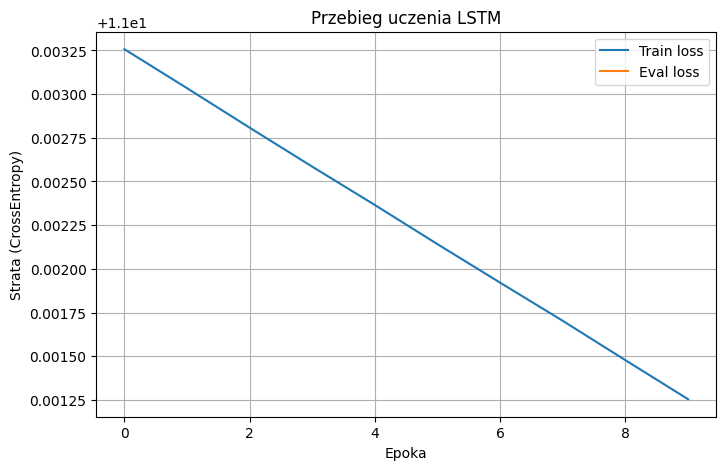

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(
    list(train_loss.keys()),
    list(train_loss.values()),
    label="Train loss",
)
plt.plot(list(eval_loss.keys()), list(eval_loss.values()), label="Eval loss")
plt.xlabel("Epoka")
plt.ylabel("Strata (CrossEntropy)")
plt.title("Przebieg uczenia LSTM")
plt.legend()
plt.grid(True)
plt.show()